# Part 2: Black Box Renyi Divergence Variational Inference

This notebook is the second of a three part series that walks the reader through a summarised version of my main thesis results.

**Recap** 

In the last notebook, we implemented black box KLVI and applied this method to a single factor confirmatory factor analysis model. In doing so, we reproduced the problem of variance underestimation that was documented by KD Dang, who implemented KLVI by analytical methods rather than black box methods.

**Notebook purpose**

In this notebook, we generalise black box KLVI so that variational inference is performed using a generalisation of the KL Divergence, called the Renyi divergence. 

## Part 2.1 Summary of Experimental Design 


### Background Theory 

Recall that the Renyi divergence for a given $\alpha > 0$ from the posterior the posterior $p(\theta)$ to any variational approximation $q(\theta)$ is given by: 

\begin{align}
{    D_{\alpha}[q \:|| \: p]}:= \frac{1}{\alpha - 1}\log \int {p(\theta)}^{1-\alpha} {q(\theta)}^{\alpha}d\theta \qquad \text{for } \alpha \in \mathbb{R}_{>0, \neq1}
\end{align}

Optimising (1) for $\alpha >=1$ should theoretically result in **zero-forcing, mode seeking** behaviour, which I established in Notebook 1 is linked to variance underestimation. Conversely, values where $\alpha <1$ should theoretically involve some blend of zero-forcing and mass covering behaviour. Therefore, the goal is to optimise (1) for some $\alpha < 1$ and see if this results in more accurate posterior estimates.

### Implementation 

Recall from Notebook 1 that to minimise ${    D_{\alpha}[q \:|| \: p]}$ in practice, we instead need maximise the VR-$\alpha$ bound:

 $$
 \text{VR}_{\alpha}:= {\frac{1}{1-\alpha}\log \:\mathbb{E}_{q}\left[\left(\frac{{p(\mathbf{x}, \,  \pmb{\theta})}}{{q(\pmb{\theta})}}\right)^{1-\alpha}\right]}
 $$, 

Furthermore, since evaluating VR-$\alpha$ directly or analytically is not feasible, we resort to a biased estimator: 

$$
\begin{align}
    &\hat{\text{VR}_{\alpha}} := \frac{1}{1-\alpha}\log \frac{1}{K}\sum_{i=1}^{i=K}\left[ 
    \left(\frac{{{p(\mathbf{x}, \,  \pmb{\theta_i})}}}{{q(\pmb{\theta_i})}}\right)^{1-\alpha}
    \right] \quad \pmb{\theta_i} \overset{iid}{\sim} q(\pmb{\theta})
\end{align}
$$

This estimator $\hat{\text{VR}_{\alpha}}$ is parametrised by both $\alpha $ and K. 

### Mathematical Significance of $\alpha$ and K 

#### The role of $\alpha $

Mathematically, the value of $\alpha>0$ parameterises the choice of divergence measure we are minimising. We know analytically that $\alpha >=1$ will enforce zero-forcing behaviour, whereas we can derive analytically that $\alpha < 1$ should enforce a blend of zero-forcing or mass-covering behaviour. Therefore we are interested in fitting the model using $\alpha < 0$. 

#### The role of K 

Li and Turner derived that $\hat{\text{VR}_{\alpha}}$ is a consistent estimator in K, so the larger the K for a fixed $\alpha$, the closer we get to the "true" optimisation objective VR-$\alpha$.

### Extending VR-$\alpha$ algorithm to $\alpha < 0$

Mathematically speaking, the Renyi divergence is not defined for $\alpha <=0$: however, the VR bound expression and the estimator $\hat{\text{VR}_{\alpha}}$ can be comfortably generalised to $\alpha <=0$. 
s
Li and Turner suggest that rather than running $\hat{\text{VR}_{\alpha}}$ for some $\alpha >0$ and huge K, it might be better to optimise $\hat{\text{VR}_{\alpha}}$ for some $\alpha <=0 $ and modest K. 

At a high level, this is because for $\alpha_1 <0$ and some finite K we can introduce a "favourable" bias. In other words, rnning the biased $\hat{\text{VR}_{\alpha}}$ algorithm for some finite K and $\alpha_1<0$ can bias the algorithm  towards estimating the theoretical objective VR-$\alpha_2$ for some $\alpha_2 > 0$ **more accurately** than the estimator $\hat{\text{VR}_{\alpha_2}}$ for that same value of K. 

Since it is not possible to analytically derive suitable values of $\alpha <0$ and K, this means that K is also a parameter of the $\hat{\text{VR}_{\alpha}}$ algorithm.

### Resulting Experimental Design 

I will fit the single factor CFA model with the following $\alpha, K$ values: 

* $\alpha \in$ {-50, -1, 0.5, 1}
* K $\in {10, 100}$

### Stochastic Optimisation 

The biased VR-$\alpha$ algorithm relies on stochastic optimisation: for every loop iteration, the gradient is estimated on a finite K sample. To mod out this stochasticity, and to study aggregate behaviours, we need to run the VR-$\alpha$ algorithm for $S=50$ times on every combination of $\alpha, K$.

### Compromise - Computational Constraints

As of June 2023, several important matrix operations are not offered on GPU for Apple M1. Thus, I utilised a CPU implementation and circumvented computational constraints by utilising a HPC cluser. 

For illustrative purposes in this noteobook, I will run a reduced set of experiments on K $\in $ {10, 20} to demonstrate the workflow whilst maintaining focus on the core insights.

In [1]:
# Imports and Global Variables

%load_ext autoreload
%autoreload 2
%load_ext tensorboard

from collections import defaultdict
from semopy.examples import holzinger39
import torch
from torch.distributions import MultivariateNormal as mvn
import pickle
from dataclasses import asdict
from itertools import product 

import sys 
sys.path.append('..')
from src.variational_sem import SingleCFAVIModel, VIOptimisationParameters
from src.analytical_variational_inference.analytical_variational_infernce import single_factor_cfa_mfvb
from src.mcmc.mcmc import single_factor_cfa_mcmc
from src.analysis.sampling import sample_from_distribution
from src.analysis.visualisation import plot_credint, plot_moments_boxplot
from src.helpers import pickle_file, unpickle_file

/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/notebooks"
  warnings.warn(
/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/rw/17130_512vz5y5_7d1l60_dh0000gn/T//Rtmprav012", R: "/var/folders/rw/17130_512vz5y5_7d1l60_dh0000gn/T//Rtmp8Qht2k"
  warnings.warn(
/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/stan/plugins.py:4: Us

In [ ]:
#GLOBAL VARIABLES 
NON_LATENT_PARAMETERS = ['nu.1', 'nu.2', 'nu.3', 'lam.1', 'lam.2', 'psi.1', 'psi.2', 'psi.3', 'sig2']
SAMPLE_SIZE = 60_000
VI_MODELS_FILEPATH = '../data/batched_vi_models/'
VI_RUNS_FILEPATH = 'tensorboard_runs/batched_vi_models/'
S_runs = 5 
VI_OPTIMISATION_PARAMETERS = VIOptimisationParameters(num_iterations = 20_000, relative_error_threshold= 1e-3, patience = 100)

## Part 2.3 Results 

In [3]:
#For loop set up 
ALPHA_VALUES = [1, 0.5, -10]
K_VALUES = [10, 20]

In [4]:
#Set up data
y_data = torch.tensor(holzinger39.get_data()[['x1', 'x2', 'x3']].values, requires_grad = False)

In [5]:
#Set Hyper-parameters 
#sig_2 ~ InvGamma
sig2_shape = torch.tensor([0.5])  
sig2_rate = torch.tensor([0.5])  

#psi ~ iid Inv Gamma for j = 1..m 
psi_shape = torch.tensor([0.5])  
psi_rate = torch.tensor([0.005])  

#nu ~ iid Normal for j = 1...m
nu_sig2 = torch.tensor([100.0])  
nu_mean = torch.tensor([0.0])

#lam_j | psi_j ~ id Normal(mu, sig2*psi_j)
lam_mean = torch.tensor([0.0])
lam_sig2 = torch.tensor([1.0])

hyper_params = {"sig2_shape": sig2_shape, "sig2_rate": sig2_rate, "psi_shape": psi_shape, "psi_rate": psi_rate, "nu_sig2": nu_sig2, "nu_mean": nu_mean, "lam_mean": lam_mean, "lam_sig2": lam_sig2}

In [ ]:
def run_batch(alpha_values: list[float], K_values: list[int], S: int, filename: str): 
    vi_models_per_alpha_K = defaultdict(list)
    for (a,k) in product(alpha_values, K_values):
        for i in range(S): 
            print(f"Running for alpha, K: {a, k} for S = {i}")
            vi_model = SingleCFAVIModel(y_data = y_data, hyper_params= hyper_params, degenerates = {})
            #Record the iteration 
            vi_model.optimize(K = k, alpha = a, optimisation_parameters = VI_OPTIMISATION_PARAMETERS, filename = filename+f"S_{i}")
            vi_models_per_alpha_K[(a, k)].append(vi_model)
    
    return vi_models_per_alpha_K

In [ ]:
batched_models = run_batch(alpha_values = ALPHA_VALUES, K_values= K_VALUES, S = 5, filename = 'tensorboard_runs/batches/batch1')

Running for alpha, K: (1, 10) for S = 0


 39%|███▊      | 7706/20000 [05:35<08:54, 22.99it/s]


VI converged at step t =  7706
Running for alpha, K: (1, 10) for S = 1


 37%|███▋      | 7305/20000 [05:23<09:22, 22.56it/s]


VI converged at step t =  7305
Running for alpha, K: (1, 10) for S = 2


 37%|███▋      | 7485/20000 [05:51<09:47, 21.31it/s]  


VI converged at step t =  7485
Running for alpha, K: (1, 10) for S = 3


 32%|███▏      | 6446/20000 [04:26<09:20, 24.17it/s]


VI converged at step t =  6446
Running for alpha, K: (1, 10) for S = 4


 57%|█████▋    | 11347/20000 [07:52<06:00, 24.02it/s]


VI converged at step t =  11347
Running for alpha, K: (1, 20) for S = 0


 41%|████▏     | 8255/20000 [11:11<15:55, 12.30it/s]


VI converged at step t =  8255
Running for alpha, K: (1, 20) for S = 1


 37%|███▋      | 7312/20000 [09:41<16:48, 12.58it/s]


VI converged at step t =  7312
Running for alpha, K: (1, 20) for S = 2


 35%|███▌      | 7004/20000 [09:08<16:57, 12.77it/s]


VI converged at step t =  7004
Running for alpha, K: (1, 20) for S = 3


 40%|███▉      | 7979/20000 [10:54<16:26, 12.19it/s]  


VI converged at step t =  7979
Running for alpha, K: (1, 20) for S = 4


 28%|██▊       | 5644/20000 [07:37<19:24, 12.33it/s]


VI converged at step t =  5644
Running for alpha, K: (0.5, 10) for S = 0


 32%|███▏      | 6456/20000 [04:12<08:48, 25.62it/s]


VI converged at step t =  6456
Running for alpha, K: (0.5, 10) for S = 1


 31%|███       | 6190/20000 [04:01<08:57, 25.68it/s]


VI converged at step t =  6190
Running for alpha, K: (0.5, 10) for S = 2


 35%|███▍      | 6942/20000 [04:48<09:01, 24.09it/s]


VI converged at step t =  6942
Running for alpha, K: (0.5, 10) for S = 3


 25%|██▌       | 5068/20000 [03:26<10:07, 24.59it/s]


VI converged at step t =  5068
Running for alpha, K: (0.5, 10) for S = 4


 25%|██▍       | 4942/20000 [03:29<10:37, 23.62it/s]


VI converged at step t =  4942
Running for alpha, K: (0.5, 20) for S = 0


 32%|███▏      | 6429/20000 [08:36<18:10, 12.44it/s]


VI converged at step t =  6429
Running for alpha, K: (0.5, 20) for S = 1


 33%|███▎      | 6582/20000 [09:00<18:22, 12.17it/s]


VI converged at step t =  6582
Running for alpha, K: (0.5, 20) for S = 2


 51%|█████     | 10228/20000 [15:04<14:23, 11.31it/s]


VI converged at step t =  10228
Running for alpha, K: (0.5, 20) for S = 3


 39%|███▉      | 7783/20000 [10:32<16:32, 12.31it/s] 


VI converged at step t =  7783
Running for alpha, K: (0.5, 20) for S = 4


 29%|██▉       | 5828/20000 [07:27<18:07, 13.03it/s]


VI converged at step t =  5828
Running for alpha, K: (-10, 10) for S = 0


 39%|███▉      | 7776/20000 [04:59<07:51, 25.93it/s]


VI converged at step t =  7776
Running for alpha, K: (-10, 10) for S = 1


 44%|████▎     | 8718/20000 [05:32<07:10, 26.21it/s]


VI converged at step t =  8718
Running for alpha, K: (-10, 10) for S = 2


 23%|██▎       | 4630/20000 [03:01<10:02, 25.50it/s]


VI converged at step t =  4630
Running for alpha, K: (-10, 10) for S = 3


 28%|██▊       | 5634/20000 [03:34<09:08, 26.21it/s]


VI converged at step t =  5634
Running for alpha, K: (-10, 10) for S = 4


 28%|██▊       | 5644/20000 [03:33<09:01, 26.49it/s]


VI converged at step t =  5644
Running for alpha, K: (-10, 20) for S = 0


 34%|███▎      | 6743/20000 [08:34<16:52, 13.10it/s]


VI converged at step t =  6743
Running for alpha, K: (-10, 20) for S = 1


 38%|███▊      | 7561/20000 [10:27<17:11, 12.06it/s]  


VI converged at step t =  7561
Running for alpha, K: (-10, 20) for S = 2


 35%|███▍      | 6909/20000 [09:12<17:26, 12.51it/s]


VI converged at step t =  6909
Running for alpha, K: (-10, 20) for S = 3


 34%|███▍      | 6825/20000 [09:06<17:34, 12.50it/s]


VI converged at step t =  6825
Running for alpha, K: (-10, 20) for S = 4


 36%|███▌      | 7146/20000 [09:43<17:29, 12.25it/s]  

VI converged at step t =  7146


In [6]:
#pickle 
#pickle_file(VI_MODELS_FILEPATH + 'batch1', batched_models)
batched_models = unpickle_file(filename = VI_MODELS_FILEPATH + 'batch1')

In [16]:
#Sample values 
df_by_alpha_k = defaultdict(list)
for (alpha, K), list_model in batched_models.items(): 
    for model in list_model:
        dist_by_var = model.qvar.qvar_by_var
        df=sample_from_distribution(dist_by_var, n = SAMPLE_SIZE)
        df_by_alpha_k[(alpha, K)].append(df)

## Convergence 

Each run of VR-$\alpha$ converged between approximately 4,000 - 11,000 iterations. 

In [ ]:
#spot check - parameter convergences 

check_tuples = [(1, 20), (0.5, 10), (-10, 20)]

for (alpha,K) in check_tuples:
    vi_model = SingleCFAVIModel(y_data = y_data, hyper_params= hyper_params, degenerates = {})
    vi_model.optimize(optimisation_parameters= VI_OPTIMISATION_PARAMETERS, filename = 'tensorboard_runs/KLVI_Model', alpha = alpha, K = K)

 35%|███▌      | 7069/20000 [09:42<17:46, 12.13it/s]


VI converged at step t =  7069


 40%|███▉      | 7927/20000 [05:29<08:22, 24.04it/s]


VI converged at step t =  7927


 30%|██▉       | 5969/20000 [08:07<19:04, 12.26it/s]

VI converged at step t =  5969


## 2.3.1 In general, KLVI $\alpha = 1$ estimates posterior means more accurately and more precisely than $\alpha < 1$

In [ ]:
#reference MCMC values 
mcmc_df = unpickle_file("../src/mcmc/mcmc_df.pickle")
mcmc_df_nonlatent = mcmc_df[NON_LATENT_PARAMETERS]
mcmc_df_nonlatent = mcmc_df_nonlatent.rename(columns = {'lam.1': 'lam.2', 'lam.2': 'lam.3'})

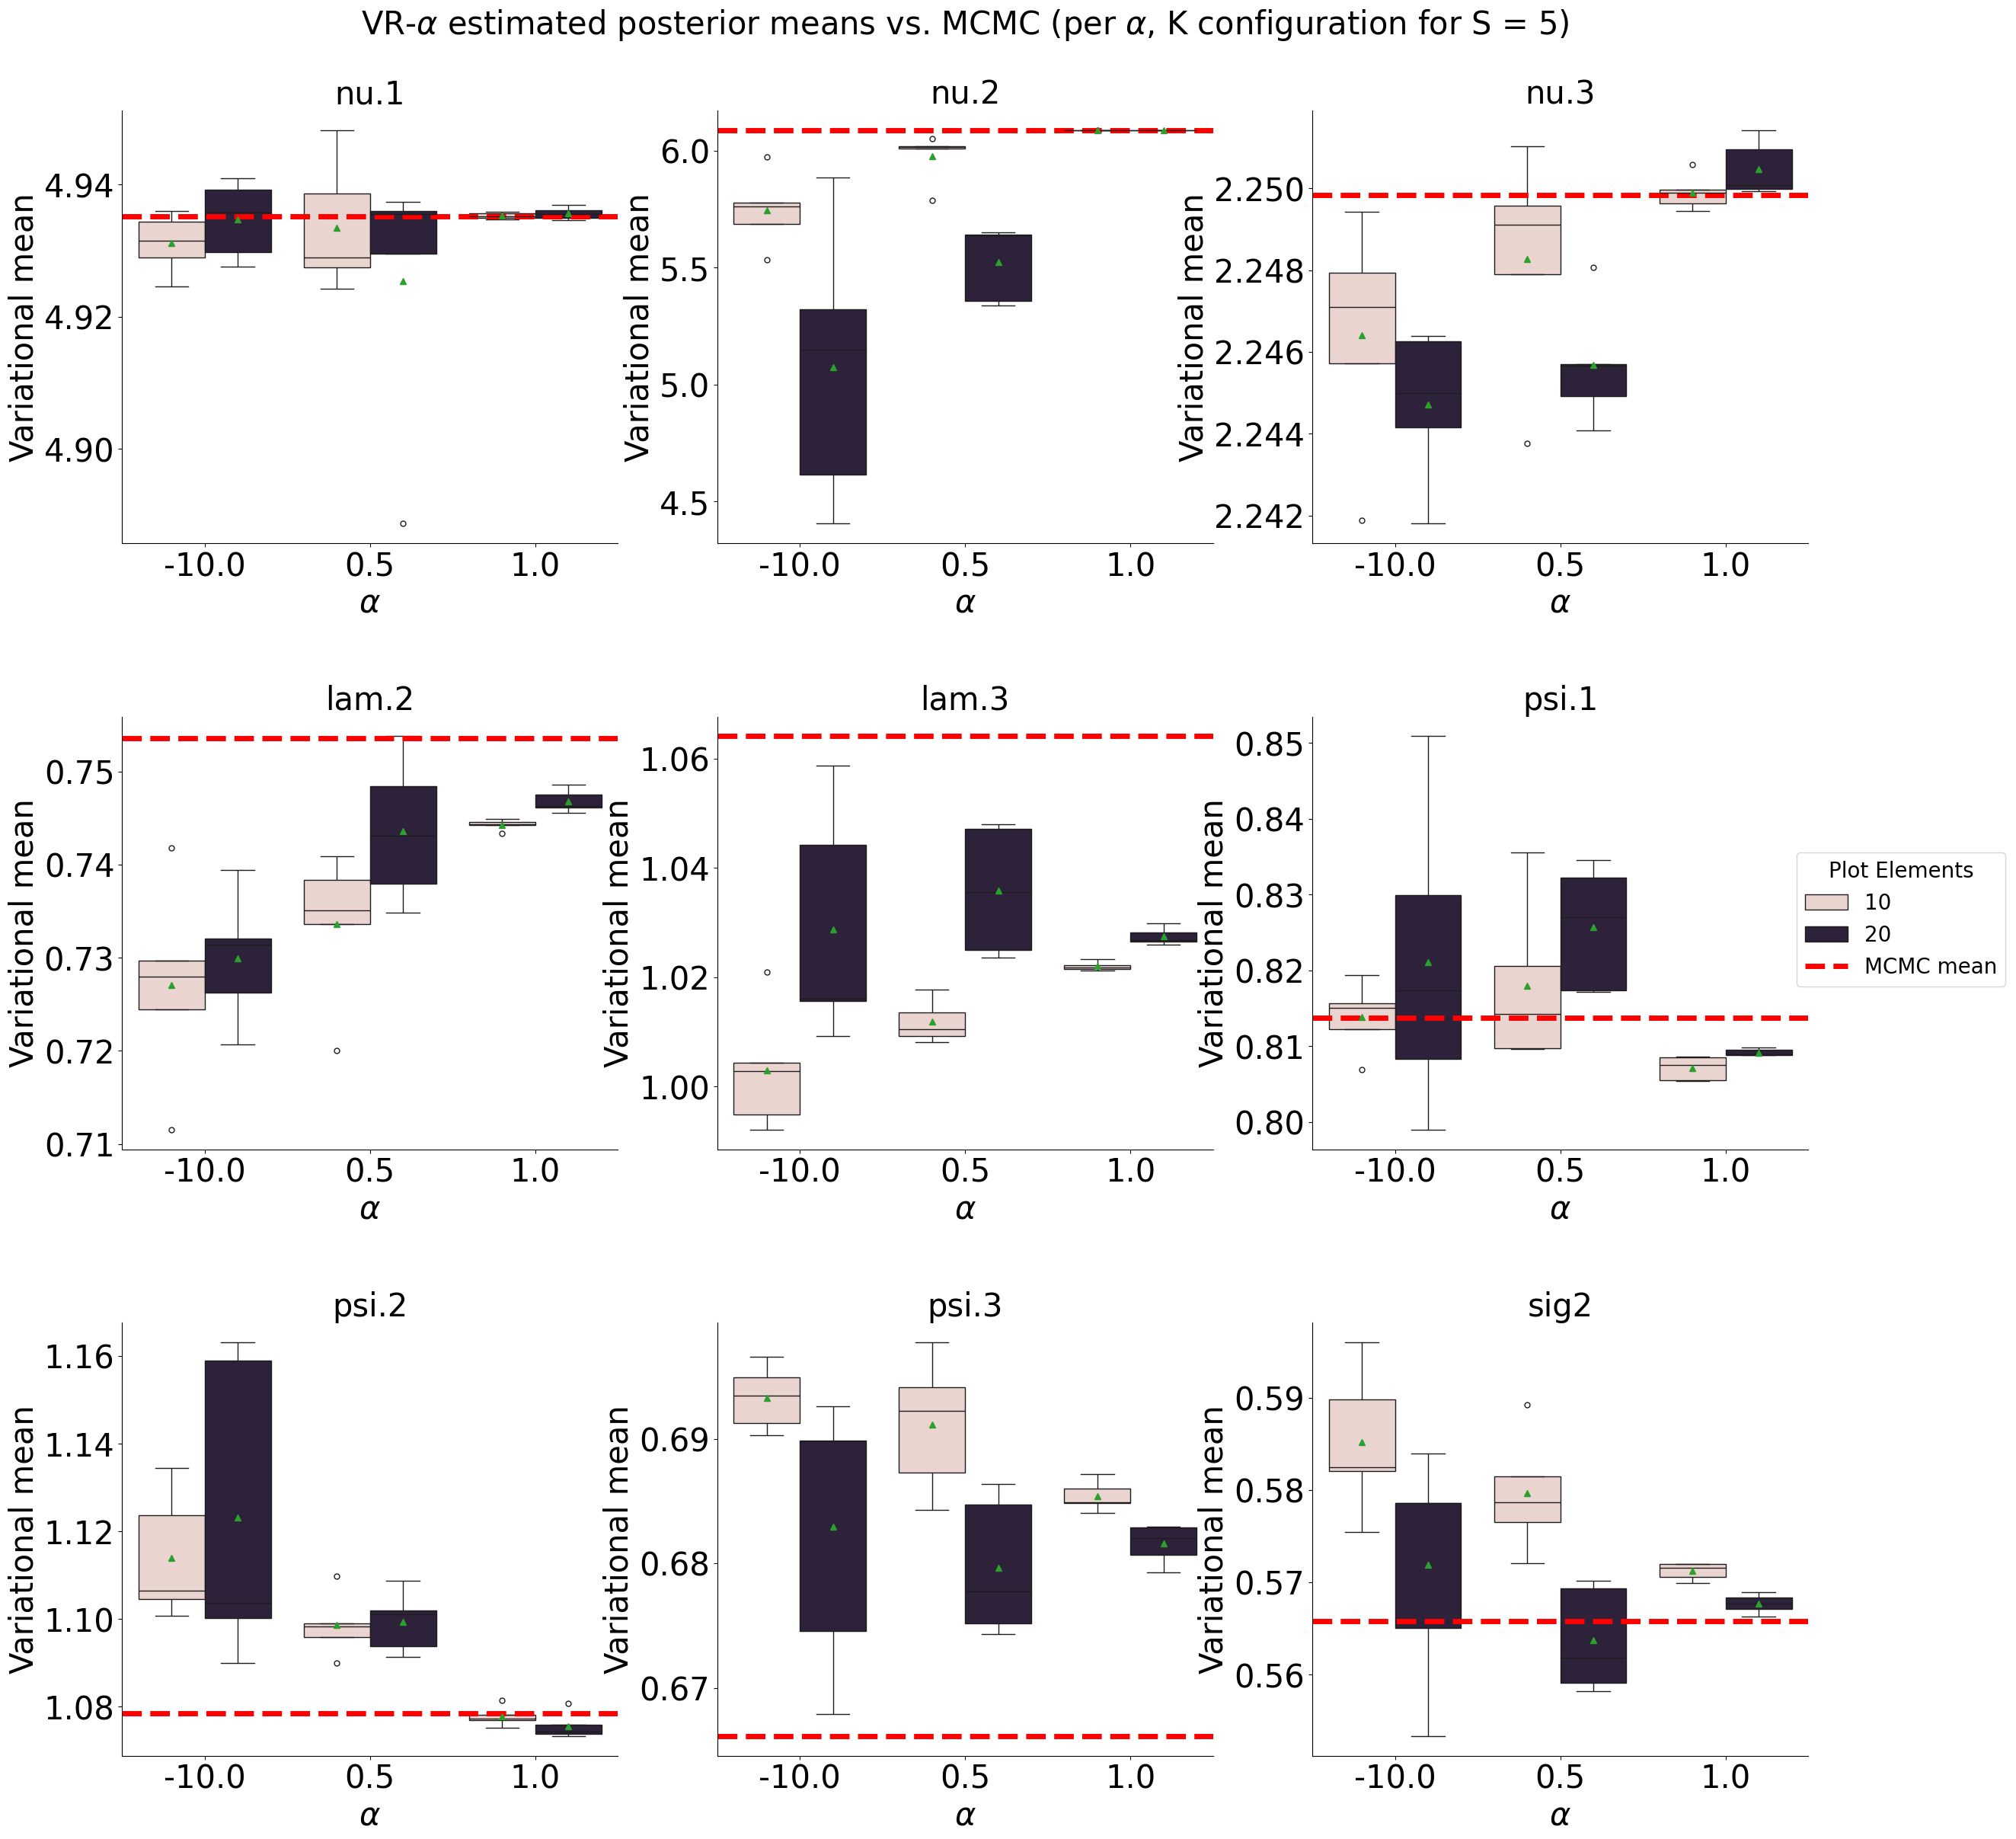

In [84]:
plot_moments_boxplot(df_by_alpha_k = df_by_alpha_k, mcmc_df = mcmc_df_nonlatent, moment = 'mean')

For each $\alpha, K$ configuration, we plot the estimated posterior mean for each of the $S = 5$ runs. For all variational parameters excuding $\lambda_{3}$ and $\psi_{1}$, we see that for both K = 10 and K = 20, it is the KLVI algorithm (using $\alpha = 1$) that estimates posterior means most accurately. 

Furthermore, KLVI posterior mean are more precise across the S = 5 runs. 

## 2.3.1.1 Actual Experimental Result: S = 50 runs 

For completeness I include the boxplot result we obtain from running on the full $\alpha, K$ set: $\alpha \in$ {-50, -1, 0.5, 1}, K $\in {10, 100}$. Results are less noisy and the superiority of KLVI for estimating posterior means is much clearer. 

<img src="/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/notebooks/external_images/boxplot_hs_prior_flat_moment_mean.png">

## 2.3.2 Larger variance estimates on $\alpha > 1$

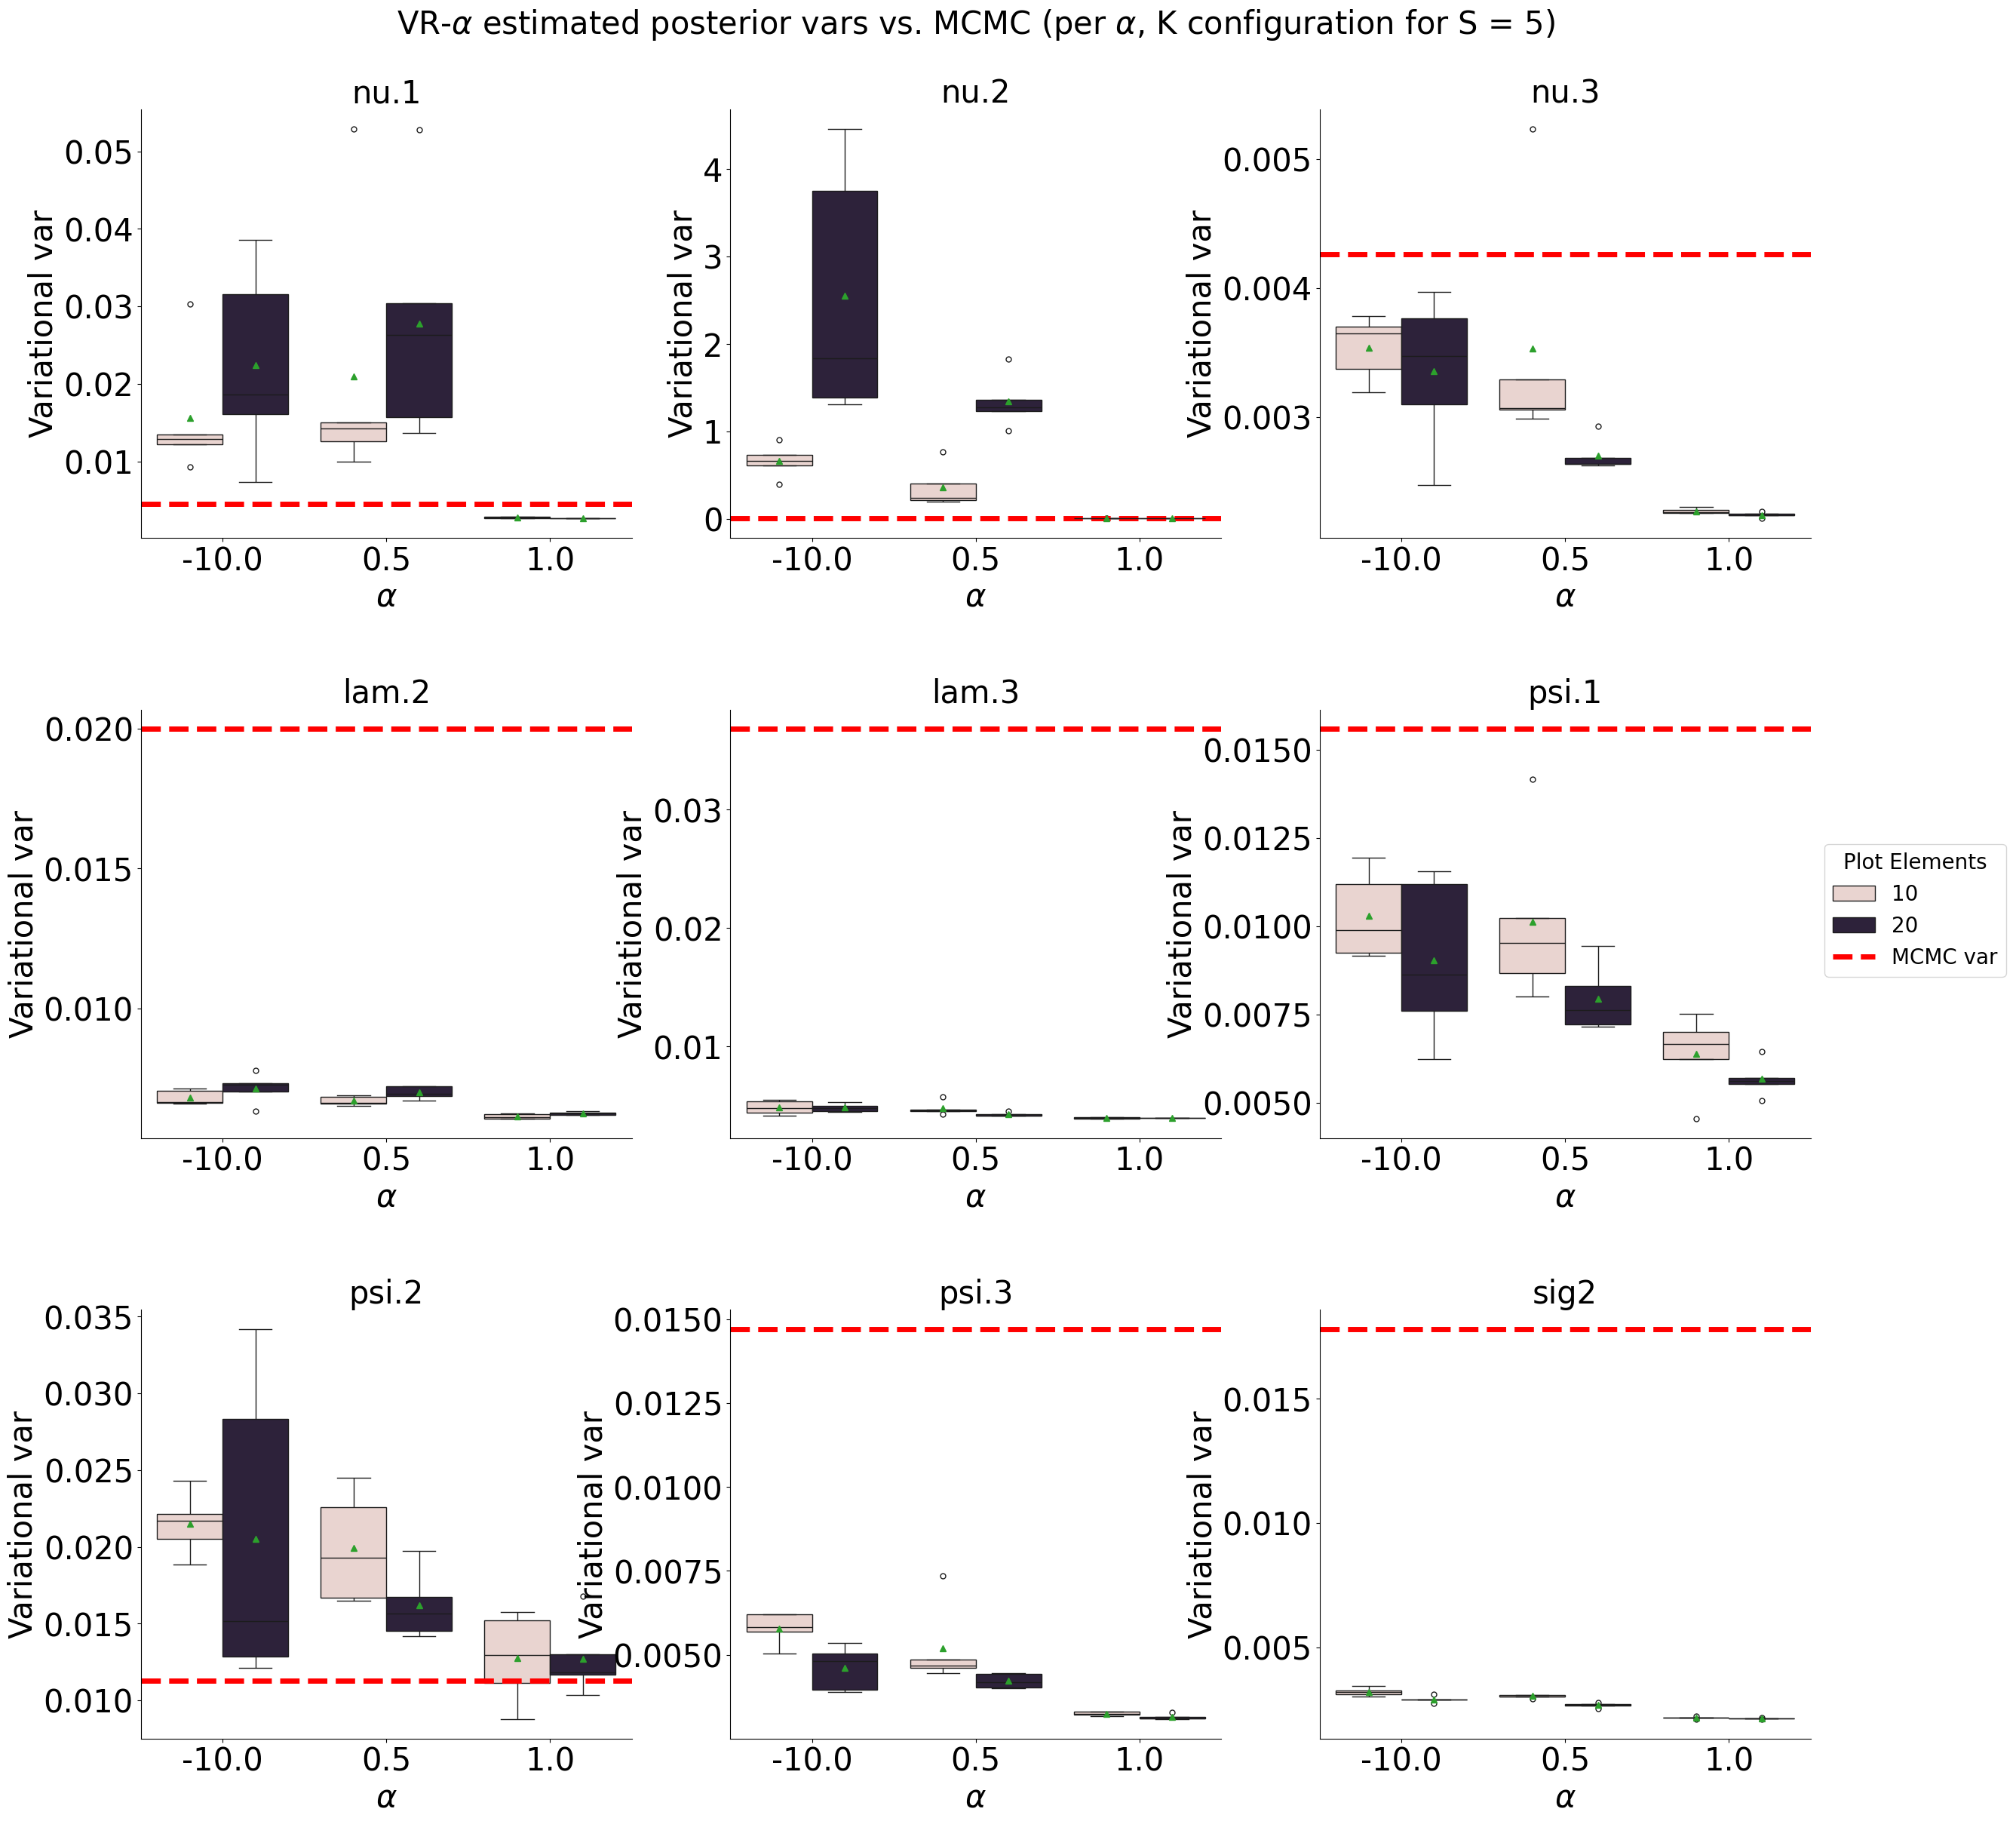

In [85]:
plot_moments_boxplot(df_by_alpha_k = df_by_alpha_k, mcmc_df = mcmc_df_nonlatent, moment = 'var')

For each $\alpha, K$ configuration, we plot the estimated posterior variances for each of the $S = 5$ runs. 

For all of the variational parameters, it is clear that using $\alpha <1$ produces larger posterior variances. Furthermore, as also established in Notebook 1, in KLVI there is a tendency toward variance underestimation. 

## 2.3.2.1 Limitations 

First, there are some caveats. First, the spread in variance estimates seems to be much larger for $\alpha <1$ than $\alpha = 1$.  Correspondingly, the VR-$\alpha$ algorithm estimates often overshoot the true posterior variance - see for example $\nu_1$. 

Furthermore, it is unclear which combination of $\alpha, K$ produces the most accurate posterior estimates across all model parameters. In addition, the size of the "improvement" differs for different model parameters.

## 2.3.2.2 Actual Experiment Results: S = 50

For completeness I include the boxplot result we obtain from running on the full $\alpha, K$ set: $\alpha \in$ {-50, -1, 0.5, 1}, K $\in {10, 100}$. We can see that results are less noisy but the overall message is the same.

<img src="/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/notebooks/external_images/boxplot_hs_prior_flat_moment_variance.png">

## Part 2.4 Other Limitations and Unexplained Patterns 

* Why is there a blow-up in the spread of variational parameter estimates (mean, variance) as we increase K? 


## Part 2.5 Next Steps 

### 2.5.1 Mean-Normalised Holzinger Swineford Dataset

### 2.5.2 Experimenting with Other Priors 